# 0. Monkey-patch

In [1]:
# SWAP OUT THE DATE FORMATTING METHOD OF pm4py - I don't like it's resolution.
import sys
import pm4py


def uncache(exclude):
    """Remove package modules from cache except excluded ones.
    On next import they will be reloaded.

    Args:
        exclude (iter<str>): Sequence of module paths.
    """
    pkgs = []
    for mod in exclude:
        pkg = mod.split('.', 1)[0]
        pkgs.append(pkg)

    to_uncache = []
    for mod in sys.modules:
        if mod in exclude:
            continue

        if mod in pkgs:
            to_uncache.append(mod)
            continue

        for pkg in pkgs:
            if mod.startswith(pkg + '.'):
                to_uncache.append(mod)
                break

    for mod in to_uncache:
        del sys.modules[mod]


intervals = (
    ('Y', (60 * 60 * 24 * 365)),
    ('M', (60 * 60 * 24 * 30)),
    ('W', (60 * 60 * 24 * 7)),
    ('D', (60 * 60 * 24)),
    ('H', (60 * 60)),
    ('m', 60),
    ('s', 1),
)


def display_time(seconds, granularity=2):
    result = []
    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append(f"{int(value)}{name}")
    return ' '.join(result[:granularity])


def my_human_readable_stat(timedelta_seconds, stat_locale: dict = {}):
    return display_time(timedelta_seconds)


pm4py.util.vis_utils.human_readable_stat = my_human_readable_stat
pm4py.visualization.common.utils.human_readable_stat = my_human_readable_stat

uncache([
    'pm4py.util.vis_utils',
    'pm4py.visualization.common.utils',
])

# 1. Import Libraries

In [2]:
import pandas as pd

import pm4py
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization

# 2. Load data

In [3]:
df = pd.DataFrame([
    # @formatter:off
    ['Alice', 'SR engineer',           pd.Timestamp('2021-01-01').timestamp()],
    ['Alice', 'SW engineer',           pd.Timestamp('2022-01-01').timestamp()],  # promo after 1 year
    ['Alice', 'Sr.SW engineer',        pd.Timestamp('2023-01-01').timestamp()],  # promo after 1 year
    ['Alice', 'Tech Fellow',           pd.Timestamp('2025-01-01').timestamp()],  # promo after 2 years
    ['Bob', 'Staff DS engineer',       pd.Timestamp('2021-01-01').timestamp()],
    ['Bob', 'SW engineer',             pd.Timestamp('2022-01-01').timestamp()],  # promo after 1 year; for demo, you had career change.
    ['Bob', 'Sr.SW engineer',          pd.Timestamp('2028-01-01').timestamp()],  # promo after *6* years
    # @formatter:on
], columns=['username', 'action', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df

,username,action,timestamp
0,Alice,SR engineer,2021-01-01
1,Alice,SW engineer,2022-01-01
2,Alice,Sr.SW engineer,2023-01-01
3,Alice,Tech Fellow,2025-01-01
4,Bob,Staff DS engineer,2021-01-01
5,Bob,SW engineer,2022-01-01
6,Bob,Sr.SW engineer,2028-01-01


In [4]:
pm_data = dataframe_utils.convert_timestamp_columns_in_df(df)
pm_data.columns = ['case:concept:name', 'concept:name', 'time:timestamp']
pm_data

,case:concept:name,concept:name,time:timestamp
0,Alice,SR engineer,2021-01-01
1,Alice,SW engineer,2022-01-01
2,Alice,Sr.SW engineer,2023-01-01
3,Alice,Tech Fellow,2025-01-01
4,Bob,Staff DS engineer,2021-01-01
5,Bob,SW engineer,2022-01-01
6,Bob,Sr.SW engineer,2028-01-01


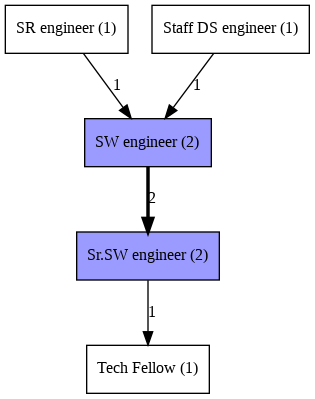

In [5]:
# Variant = Frequency
log = log_converter.apply(pm_data)
variant = dfg_visualization.Variants.FREQUENCY
dfg = dfg_discovery.apply(log)
gviz = dfg_visualization.apply(dfg, log=log, variant=variant)
dfg_visualization.view(gviz)

In [6]:
log = log_converter.apply(pm_data)
dfg, start_activities, end_activities = pm4py.discover_dfg(log)

In [7]:
dfg.most_common(25)

[(('SW engineer', 'Sr.SW engineer'), 2),
 (('SR engineer', 'SW engineer'), 1),
 (('Sr.SW engineer', 'Tech Fellow'), 1),
 (('Staff DS engineer', 'SW engineer'), 1)]

In [8]:
start_activities

{'SR engineer': 1, 'Staff DS engineer': 1}

In [9]:
end_activities

{'Tech Fellow': 1, 'Sr.SW engineer': 1}

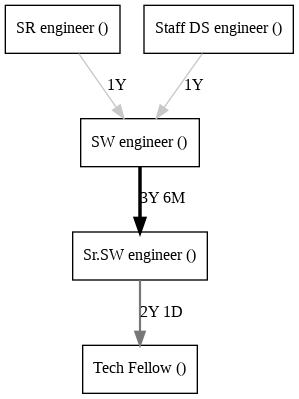

In [10]:
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)